# Detecting Gravitational Waves - Group 1 ITBA

### Nicolás de León
### Matías Larroque

## First Step: Collecting Dataset and Inspection

There are two datasets that correspond to signals received by Hanford's and Livingston's interferometer.



Each dataset consists in a 32 seconds of strain samples at a sample rate of 4096. This makes it a total of 131072 strain samples.

### Imports

In [32]:
# General imports and libraries used
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import scipy.signal as signal
import seaborn as sns
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

### Download Files

In [33]:
if not (os.path.exists('H-H1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5')):
  !wget "https://raw.githubusercontent.com/mlarroque/Adaptative-Processing-1/master/H-H1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5"
if not (os.path.exists('L-L1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5')):
  !wget "https://raw.githubusercontent.com/mlarroque/Adaptative-Processing-1/master/L-L1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5"

### Dataset Metadata Inspection

Lets see what information does the dataset provide

In [34]:
h1_dataset = h5py.File('H-H1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5', 'r')
l1_dataset = h5py.File('L-L1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5', 'r')

for data in h1_dataset['meta']:
  print(f'{data}: ', h1_dataset['meta'][data][()])

start_time = h1_dataset['meta']['GPSstart'][()]

Description:  b'Strain data time series from LIGO'
DescriptionURL:  b'http://www.gw-openscience.org/'
Detector:  b'H1'
Duration:  32
GPSstart:  1126259447
Observatory:  b'H'
Type:  b'StrainTimeSeries'
UTCstart:  b'2015-09-14T09:50:30'


### Plot: Strain Time Series



Now lets plot each strain and visualize the data in time. Lets output a audio file with the 32s for further inspection.

Taking into account the chirp time we will plot a sequence of time containing the event to see if we can perceive a signal.

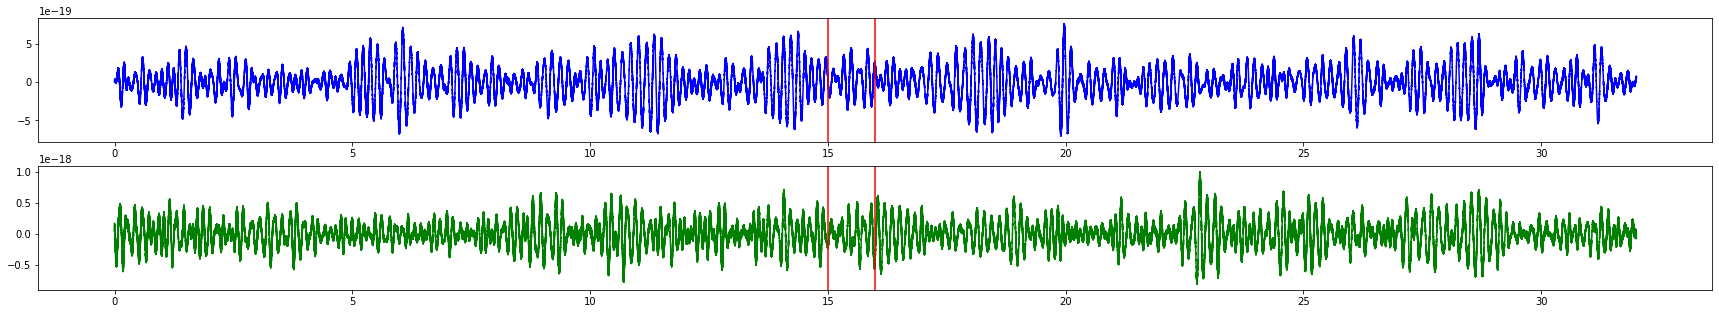

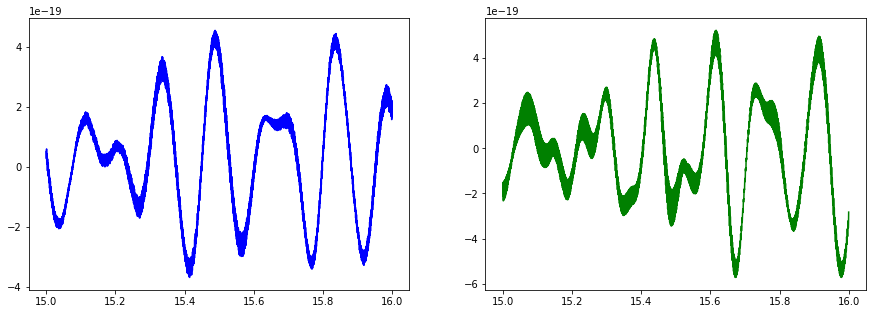

In [35]:
h1_dataset = h5py.File('H-H1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5', 'r')['strain']['Strain']
l1_dataset = h5py.File('L-L1_GWOSC_4KHZ_R1-1126259447-32-source.hdf5', 'r')['strain']['Strain']
l1_dataset = l1_dataset - np.mean(l1_dataset)
# It is known that exists a 10ms max delay between two datasets...

fs = 4096
chirp_time = 1126259462.5   # Chrip_time in which is suposed to find de gravitational wave.
figure, axes = plt.subplots(nrows=2, figsize=(30, 5))

x_in_seconds = np.arange(0, 32, 1/fs)
chirp_second_min = ((chirp_time - start_time)*fs - 0.500*fs)
chirp_second_max = ((chirp_time - start_time)*fs + 0.500*fs)

axes[0].plot(x_in_seconds, h1_dataset, color='b')
axes[0].axvline(x=chirp_second_min/fs, color='r')
axes[0].axvline(x=chirp_second_max/fs, color='r')
axes[1].plot(x_in_seconds, l1_dataset, color='g')
axes[1].axvline(x=chirp_second_min/fs, color='r')
axes[1].axvline(x=chirp_second_max/fs, color='r')

figure, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0].plot(
    x_in_seconds[int(chirp_second_min):int(chirp_second_max)], 
    h1_dataset[int(chirp_second_min):int(chirp_second_max)],
    color='b'
    )
axes[1].plot(
    x_in_seconds[int(chirp_second_min):int(chirp_second_max)], 
    l1_dataset[int(chirp_second_min):int(chirp_second_max)],
    color='g'
    )

Audio(h1_dataset, rate=4096)

It seems that the chirp is submerged in noise and we aren't able to retrieve it at plain sight or hear the event.

## Spectral estimation with periodogram

In order to calculate both dataset's noise periodogram, we will  perform a Fourier Transform, applying square modulus and then dividing by the number of samples, as indicated by the following expression:  

$$\hat{R_x} = \frac{1}{N} \lvert {\sum_{n=0}^{N - 1} x(n)w(n)e^{-jwn}} \rvert^2 = \frac{1}{N} {\lvert V(e^{-jw}) \rvert}^2$$

where $V(e^{-jw})$ is the DTFT of the windowed secuence $v(n) = x(n)w(n)$

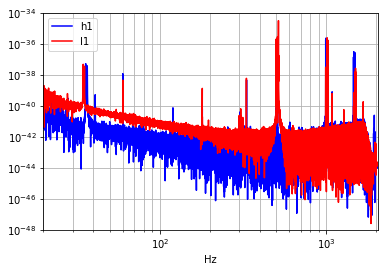

In [36]:
def periodogram_manual(dataset, color_plot):
  FFTk = abs(np.fft.rfft(dataset))**2 / len(dataset)
  freq_axis = np.fft.rfftfreq(len(dataset), d=1/fs)   # Each k-th FFT output is asociated with w(k) = 2*pi*k/len(dataset)
  plt.loglog(freq_axis, FFTk, color_plot)
  plt.xlim(20, fs/2)
  plt.ylim(1e-48, 1e-34)
  plt.xlabel('Hz')
  plt.grid(True, which="both")

plt.figure()
periodogram_manual(h1_dataset, 'b')
periodogram_manual(l1_dataset, 'r')
plt.legend(['h1', 'l1'])


We can notice that this estimation isn't optimal taking into account the amount of noise observed. Before stepping into more precise estimators, lets contrast the periodogram estimator obtained by performing autocorrelation and DTFT.
$$ \hat{R_x}(e^{jw}) = \sum_{l=-(N-1)}^{N - 1} \hat{r}_x(l) e^{-jwl} $$ 

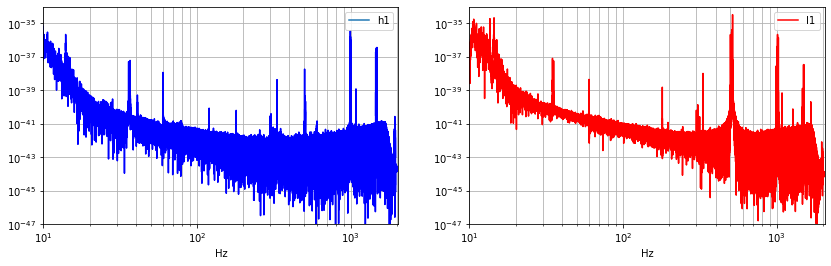

In [37]:
# Podemos verificar el periodograma realizando la autocorr y despues dtft
auto_corr_h1 = np.correlate(h1_dataset, h1_dataset, mode = 'full') # Esto devuelve un vector de 2N - 1
auto_corr_l1 = np.correlate(l1_dataset, l1_dataset, mode ='full') # Esto devuelve un vector de 2N - 1


FFTk_h1 = abs(np.fft.rfft(auto_corr_h1)) / len(h1_dataset)
FFTk_l1 = abs(np.fft.rfft(auto_corr_l1)) / len(l1_dataset)

figure, axes = plt.subplots(ncols=2, figsize=(14, 4))
freq_axis = np.fft.rfftfreq(2*len(h1_dataset)-1, d=1/fs)

axes[0].loglog(20, fs/2)
axes[0].axis(xmin=10, xmax=fs/2)
axes[0].axis(ymin=1e-47, ymax=1e-34)
axes[0].semilogy(freq_axis, FFTk_h1, color='b')
axes[0].set_xlabel('Hz')
axes[0].grid(True, which="both")
axes[0].legend(['h1'])
axes[1].semilogy(freq_axis, FFTk_l1, color='r')
axes[1].loglog(20, fs/2)
axes[1].axis(xmin=10, xmax=fs/2)
axes[1].axis(ymin=1e-47, ymax=1e-34)
axes[1].set_xlabel('Hz')
axes[1].grid(True, which="both")
axes[1].legend(['l1'])


We can see the same noisy estimator

## Blackman Tucky (periodograma Smothing)
Given a data sequence $[0, N-1]$ Blackman-Tucky periodogram estimation suggests performing the convolution in the frequency domain between our periodogram estimator and a rectangular window, smoothing the periodogram estimator.

$$ \hat{R}^{(PS)}_x(e^{jw}) = \hat{R_x}(e^{jw}) \circledast W_a(e^{jw})$$

In practice, we achive this a bit diferently.

We first obtain our autocorrelation sample vector in the range of $ -L+1 $ and $ L - 1 $.

Then we multiply by the inverse of the rectangular window with the characteristics shown below:

$$ w_a(l) = \frac{sin(l \Delta w/2)}{\pi l}  $$ 

The overall result is obtained after applying the DFT.

$$ \hat{R}^{(PS)}_x(e^{jw}) = \sum_{l=- (L-1)}^{L - 1} \hat{r}_x(l) w_a(l) e^{-jwl}$$

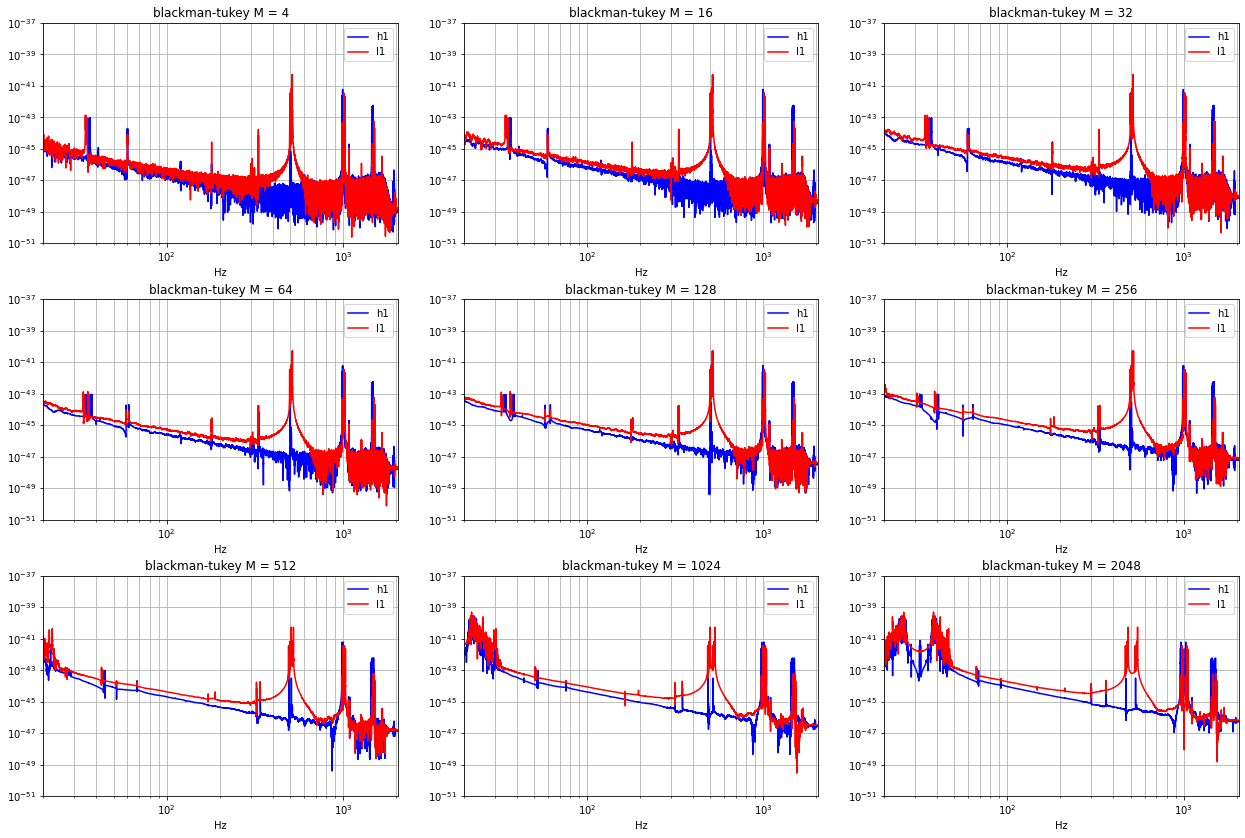

In [38]:
def window_B_T(l, M, N, L):
  l = l-L
  delta_w = 2 * np.pi * ((M + 1) / N)
  if l == 0:
    ret = 1
  else:
    ret = np.sin(delta_w * l / 2) / (l * np.pi)
  if np.isnan(ret):
    print(l)
  return ret

def blackman_tukey(dataset, M):
  """
  inputs: signal samples, M (overlap)
  """

  # first step, estimate autocorrelation:
  N = len(dataset)
  r_hat = np.correlate(dataset, dataset, mode='full')/N

  # second step, windowing:
  L = int(N)
  Ls = np.array(np.linspace(-L+1, L-1, 2*L-1)).astype(int)

  # wl = np.blackman(M + 1).repeat(int(len(Ls)/M + 1))
  r_hat_window_mpy = [r_hat[i+L-1]*(window_B_T(i, M, N, L)) for i in Ls]

  # third and last step, DFT/FFT:
  fs = 4096
  FFT = abs((np.fft.rfft(r_hat_window_mpy)))
  freq_axis = np.fft.rfftfreq(len(r_hat_window_mpy), d=1/fs)
  return FFT, freq_axis

Ms = [4, 16, 32, 64, 128, 256, 512, 1024, 2048]
plt_data = {}
for m in Ms:
  FFT_h1, f = blackman_tukey(h1_dataset, m)
  FFT_l1, f = blackman_tukey(l1_dataset, m)
  plt_data[m] = {'x': f, 'y_h1': FFT_h1, 'y_l1': FFT_l1}

def plot_spectrum_LIGO(plt_data, n_row, n_col, txt):
  figure, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(18, 12))
  figure.tight_layout(pad=3.5)
  for i, m in enumerate(plt_data):
    axes[i // (len(plt_data) // n_row)][i % n_col].loglog(plt_data[m]['x'], plt_data[m]['y_h1'], 'b')
    axes[i // (len(plt_data) // n_row)][i % n_col].loglog(plt_data[m]['x'], plt_data[m]['y_l1'], 'r')
    axes[i // (len(plt_data) // n_row)][i % n_col].set_title(f'{txt} = {m}')
    axes[i // (len(plt_data) // n_row)][i % n_col].axis(xmin=20, xmax=fs/2)
    axes[i // (len(plt_data) // n_row)][i % n_col].axis(ymin=1e-51, ymax=1e-37)
    axes[i // (len(plt_data) // n_row)][i % n_col].set_xlabel('Hz')
    axes[i // (len(plt_data) // n_row)][i % n_col].grid(True, which="both")
    axes[i // (len(plt_data) // n_row)][i % n_col].legend(['h1', 'l1'])


plot_spectrum_LIGO(plt_data, 3, 3, 'blackman-tukey M')

#### Choosing M in Blackman - Tukey Method:

Increasing M (size of the frequency window used to peak the adjacent spectrum in orden to apply smoothing) the variance is reduced by 2M + 1, compared to the periodogram. However, the spectral resolution is increased by the same factor. So, it is convenient choose a higher M as long as there is no distorsion because of the lack of resolution in the frequency space.

Having this into account, it can be observed that M equal 128 is a value that conserve a rational relation between two aspects.




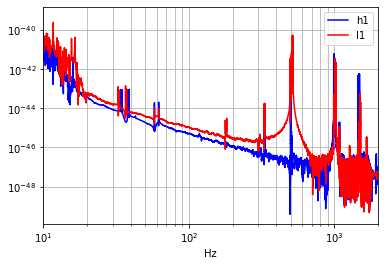

In [9]:
M_choosed = 128
FFT_h1, f_h1 = blackman_tukey(h1_dataset, M_choosed)
FFT_l1, f_l1 = blackman_tukey(l1_dataset, M_choosed)

def plot_h1_l1(res_h1, res_l1):
  plt.loglog(f, res_h1, 'b')
  plt.loglog(f, res_l1, 'r')
  plt.xlim(10, 2000)
  plt.legend(["h1", "l1"])
  plt.xlabel('Hz')
  plt.grid(True, which="both")
  plt.show() 

plot_h1_l1(FFT_h1, FFT_l1)


With this method, the noise power in h1 was reduced compared with l1's noise, specially in 500Hz, that corresponds with a shot noise in that frequency and it's affected also for an spectral leakage...
On the other hand this method reach the goal of reducing the variance obtained with simple periodogram. Also the all the noise power level was reduced with this method because the spectral leakage is lower.

## Estimation Welch - Bartlett Method (Periodogram Averaging)

Welch - Bartlett suggets a periodogram averaging method, where we can average $ K $ periodograms obtained from $ K $ different segments. Each segment is composed of $ L $ samples and we define a factor $ D $ of overlap between segments.

$$ \hat{R}^{(PA)}_x(e^{jw}) = \frac{1}{K} \sum_{i=0}^{K - 1} \hat{R}_{x,i}(e^{jw}) = \frac{1}{KL} \sum_{i=0}^{K - 1} \lvert X_{i}(e^{jw}) \rvert^2 $$

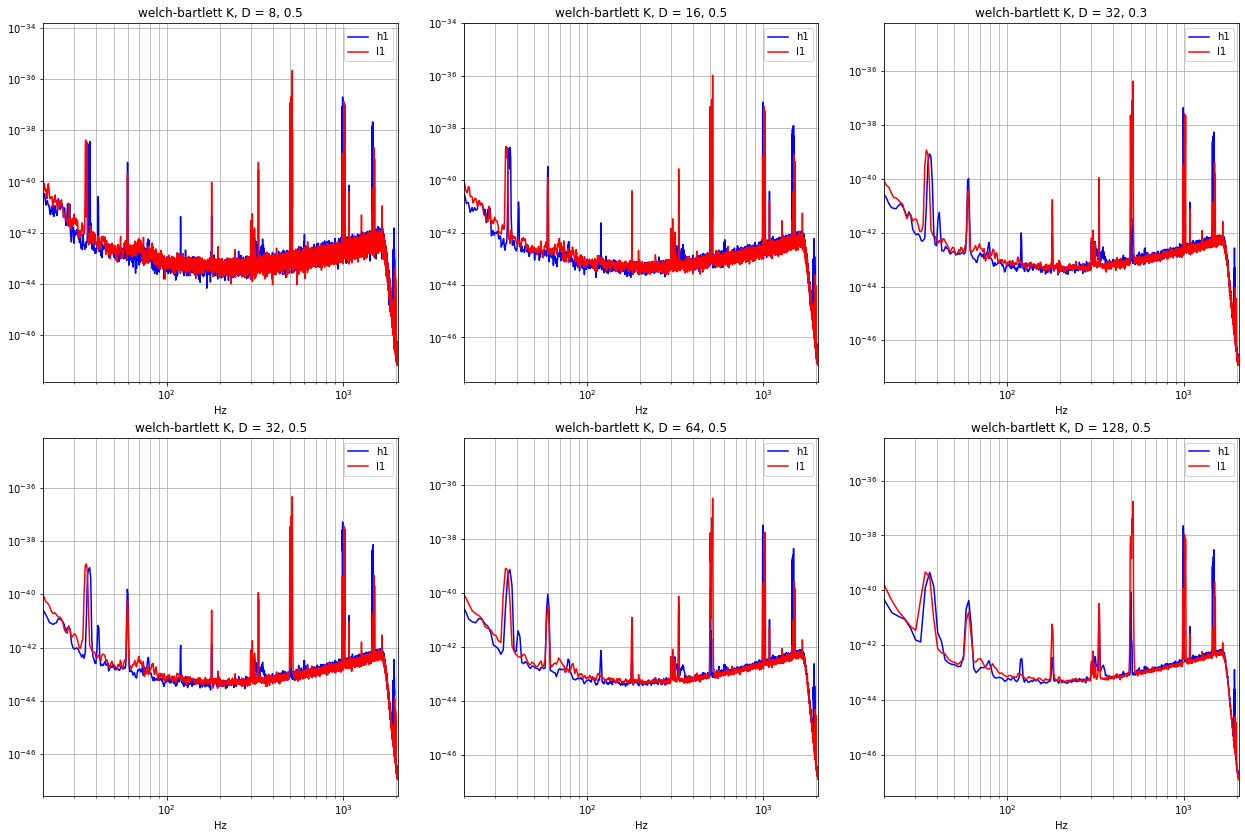

In [10]:
import scipy.signal as sp
def welch_bartlett(dataset, K, D):
  """ 
  inputs: dataset (signa data),
       k (number of periodograms to average),
       D (overlap in %) 
  """
  N = len(dataset)
  sizeWindow = int(N/((K-1)*(1-D)+1))
  step = int(sizeWindow*(1-D))
  # window_welch = sp.hanning(sizeWindow, sym=True)
  window_welch = sp.windows.hann(sizeWindow, sym=True)
  
  # First step, windowing:
  x_k = [dataset[k*step:k*step + sizeWindow]*window_welch for k in range(K)]   # limit: k = K-1 
                                                                               # --> k*step + sizeWindow = N 
  # Second Step, calculate S_k = abs(DFT/FFT)**2 for each secuence x_k:
  S_k = [abs(np.fft.rfft(x_k[i]))**2 for i in range(K)]
  fs = 4096
  freq_axis = np.fft.rfftfreq(len(x_k[0]), d=1/fs) 
  
  # Third Step, calculate average:
  averaged_S = np.sum(S_k, axis=0) / (len(S_k) * sizeWindow)

  return freq_axis, averaged_S


Ks_overlaps = [[8, 0.5], [16, 0.5], [32, 0.3], [32, 0.5], [64, 0.5], [128,0.5]]
plt_data = {}
for param in Ks_overlaps:
  f, S_h1 = welch_bartlett(h1_dataset, param[0], param[1])
  f, S_l1 = welch_bartlett(l1_dataset, param[0], param[1])
  plt_data[tuple(param)] = {'x': f, 'y_h1': S_h1, 'y_l1': S_l1}

def plot_spectrum_LIGO_welch(plt_data, n_row, n_col):
  figure, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(18, 12))
  figure.tight_layout(pad=3.5)
  for i, param in enumerate(plt_data):
    axes[i // (len(plt_data) // n_row)][i % n_col].loglog(plt_data[param]['x'], plt_data[param]['y_h1'], 'b')
    axes[i // (len(plt_data) // n_row)][i % n_col].loglog(plt_data[param]['x'], plt_data[param]['y_l1'], 'r')
    axes[i // (len(plt_data) // n_row)][i % n_col].set_title("welch-bartlett K, D = " + str(param[0]) + ", " + str(param[1]))
    axes[i // (len(plt_data) // n_row)][i % n_col].axis(xmin=20, xmax=fs/2)
    axes[i // (len(plt_data) // n_row)][i % n_col].set_xlabel('Hz')
    axes[i // (len(plt_data) // n_row)][i % n_col].grid(True, which="both")
    axes[i // (len(plt_data) // n_row)][i % n_col].legend(['h1', 'l1'])

plot_spectrum_LIGO_welch(plt_data, 2, 3)

##### Choosing "K" in Welch-Bartlett Method:

It can be observed that increasing K, the variance is reduced, and that´s  make sense beacause if K is higher, then there are more periodograms to average. On the other hand, a big K value could lose a lot of details in the real spectrum beacause the segment in which it is applied the periodogram could not represents the real spectrum.

It is possible to see that a value of K equal to 32 is the most reasonable, with overlap of 30%.

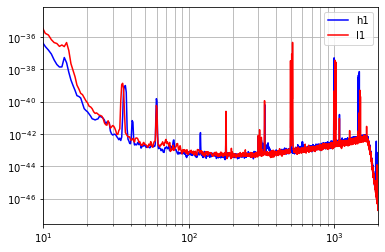

In [39]:
def plot_h1_l1(res_h1, res_l1,f):

  plt.loglog(f, res_h1, 'b')
  plt.loglog(f, res_l1, 'r')
  plt.xlim(10, 2000)
  plt.grid(True, which="both")
  plt.legend(["h1", "l1"])
  plt.show()

K_choosen = 32
D_choosen = 0.5
f_w_b, h1_welch_bartlett = welch_bartlett(h1_dataset, K_choosen, D_choosen)
f_w_b, l1_welch_bartlett = welch_bartlett(l1_dataset, K_choosen, D_choosen)
plot_h1_l1(h1_welch_bartlett, l1_welch_bartlett, f_w_b)

It can be observed the h1's higher level of noise power in the lowest frequencies, that can be explained by a higher thermal noise or more pressure radiation in that interferometer's measure. By the way, the difference between the spectrum at mid and high frequencies is too low, and this was reached because of the reduction of spectral leakage using the windows of the method and the average in time... Spectral average have better results in this sense compared to Spectral smoothing.  

# Multipaper DPSS Estimation

For each Slepian sequence window $ẉ_k(n) $ we can perform a periodogram estimation given by the formula.

$$ \hat{R}_{k,x}(e^{jw}) = \frac{1}{N} \lvert \sum_{n=0}^{N - 1} w_{k}(n)x(n)e^{-jwn} \rvert^2 $$

Then we average the $ K $ estimations.

$$ \hat{R}^{(MT)}_{x}(e^{jw}) = \frac{1}{K} \sum_{k=0}^{K - 1} \hat{R}_{k,x}(e^{jw}) $$

By peforming this we end up with what we call Multitaper DPPS periodogram estimation (MT).

In [40]:
def multipaper_dpss(dataset, N, alpha, k, fs):
  """
  Realiza el promedio de periodogramas obtenidos de una
  secuencia de K ventanas DPSS (secuencias lepianas)
  Inputs: N -> cantidad de samples
          alpha -> Caracteristica de la señal dspss
          k -> cantidad de señales
          fs -> frecuencia de sampling del dataset
  """
  periodogram_mt = np.zeros((N // 2) + 1)
  tapers_slepianos = signal.windows.dpss(N, alpha, k, norm='subsample')
  for k in range(tapers_slepianos.shape[0]):
     periodogram_mt = np.add(periodogram_mt, abs(np.fft.rfft(dataset*tapers_slepianos[k]))**2)
  freq_axis = np.fft.rfftfreq(N, d=1/fs) 

  return periodogram_mt / N, freq_axis

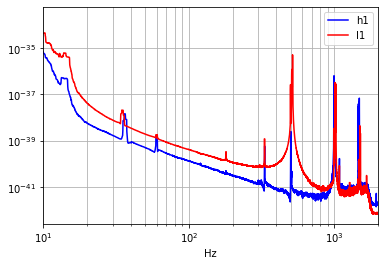

In [13]:
def plot_h1_l1(res_h1, res_l1, f):

  plt.loglog(f, res_h1, 'b')
  plt.loglog(f, res_l1, 'r')
  plt.xlim(10, 2000)
  plt.xlabel('Hz')
  plt.grid(True, which="both")
  plt.legend(["h1", "l1"])
  plt.show()
  
res_h1, f = multipaper_dpss(h1_dataset, len(h1_dataset), 20, 50, fs=4096)
res_l1, f = multipaper_dpss(l1_dataset, len(h1_dataset), 20, 50, fs=4096)

plot_h1_l1(res_h1, res_l1, f)


After defining our algorithm to perform the estimation we need to fix our value $ K $. This leads us to find the optimum $ K $ for the estimation

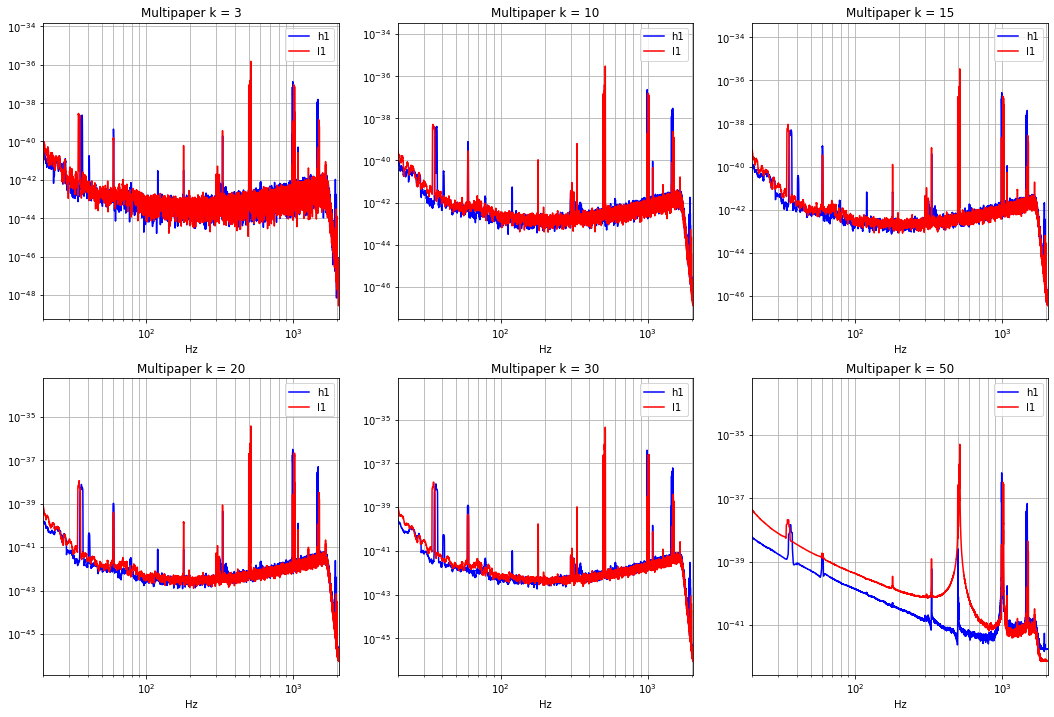

In [14]:
iter_k = [3, 10, 15, 20, 30, 50]
plt_data = {}
for k in iter_k:
  res_h1, f = multipaper_dpss(h1_dataset, len(h1_dataset), 20, k, fs=4096)
  res_l1, f = multipaper_dpss(l1_dataset, len(h1_dataset), 20, k, fs=4096)
  plt_data[k] = {'x': f, 'y_h1': res_h1, 'y_l1': res_l1}

N_ROWS, N_COLS = (2, 3)
figure, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(18, 12))
for i, k_plot in enumerate(plt_data):
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].loglog(plt_data[k_plot]['x'], plt_data[k_plot]['y_h1'], 'b')
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].loglog(plt_data[k_plot]['x'], plt_data[k_plot]['y_l1'], 'r')
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].set_title(f'Multipaper k = {k_plot}')
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].grid(True, which="both")
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].legend(["h1", "l1"])
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].set_xlabel('Hz')
  axes[i // (len(plt_data) // N_ROWS)][i%N_COLS].axis(xmin=20, xmax=fs/2)

After trying several cases of $ K $ we can observe that if we bump $ K $ to 50, the estimation starts to loose overall detail although it increases selectivity. The increasing $ K $ reduces the noise of the estimation. We choose $ K = 30 $ like optimum value where we don't loose to much detail and still make significant noise reduction.

# Contrast Estimations

We can see that estimations follow certain patterns distinctively of the method we used to estimate the power spectrum. It is noticeable, both for L1 and H1 in all estimations, power peaks for 10KHz, 15KHz, 500Hz and approx. 300Hz.

We can also see that of the estimations blackman tukey is the one that most distorts the spectrum in the lower frequencies in comparison to Welch Barlett and Multipaper.

Taking into account the Ligo detection zone and the strain values for each signal, we can assume that the event frequency components are beyond 30Hz due to seismic noise interference.

# Stationary Noise Analysis

We can validate noise stationarity realizing the probability distribution and estimating the PSD in two diferent segments at the start/end of the signal. 

## Probability Distribution


H1 and L1 dataset is divided in 4 segments of 37268 samples. We will analyze for the first and last segment of each dataset the probabiliy distributions.

In [15]:
pdf = pd.DataFrame.from_dict({
     'h1_first': h1_dataset[:len(h1_dataset)//4],
     'h1_last': h1_dataset[int(len(h1_dataset)*3/4):],
     'l1_first': l1_dataset[:len(h1_dataset)//4],
     'l1_last': l1_dataset[int(len(h1_dataset)*3/4):]
     })

pdf.describe()

,h1_first,h1_last,l1_first,l1_last
count,3.276800e+04,3.276800e+04,3.276800e+04,3.276800e+04
mean,-3.029668e-22,6.767136e-21,-1.037768e-21,-4.294938e-22
std,1.996209e-19,2.068260e-19,1.900272e-19,2.452404e-19
min,-6.806280e-19,-6.188157e-19,-6.129020e-19,-6.991827e-19
25%,-1.198979e-19,-1.264796e-19,-1.232396e-19,-1.516680e-19
50%,1.509845e-22,3.108692e-21,-5.931644e-21,-6.299668e-22
75%,1.172470e-19,1.384032e-19,1.305647e-19,1.496863e-19
max,7.221351e-19,6.387232e-19,5.665128e-19,7.134680e-19


Text(0.5, 0, 'Strain')

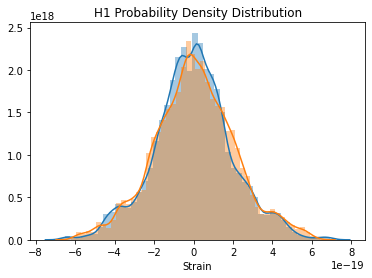

In [16]:
sns.distplot(pdf['h1_first'])
sns.distplot(pdf['h1_last'])
plt.title("H1 Probability Density Distribution")
plt.xlabel("Strain")

Text(0.5, 0, 'Strain')

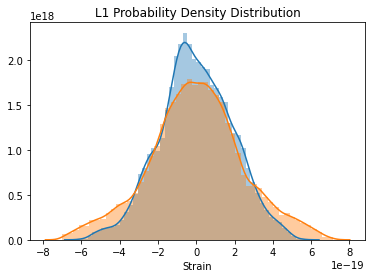

In [17]:
sns.distplot(pdf['l1_first'])
sns.distplot(pdf['l1_last'])
plt.title("L1 Probability Density Distribution")
plt.xlabel("Strain")

From the data analysis we can observe that the probability distribution for each segment, L1 and H1, at the start and end of the dataset have similar characteristics with a very similar standard diviation (diference between them is a order of magnitude smaller than the Strain values) and for both cases and means very close to 0.

## Spectrum

We will compare the power spectral density of the segments to see if there are noticeable differences between them

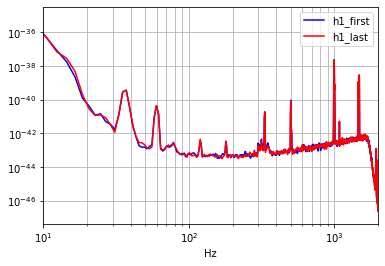

In [18]:
f_h1_first, S_h1_first = welch_bartlett(pdf['h1_first'], 32, 0.5)
f_h1_last, S_h1_last = welch_bartlett(pdf['h1_last'], 32, 0.5)
plt.loglog(f_h1_first, S_h1_first, 'b')
plt.loglog(f_h1_last, S_h1_last, 'r')
plt.xlim(10, 2000)
plt.grid(True, which="both")
plt.xlabel("Hz")
plt.legend(["h1_first", "h1_last"])
plt.show()

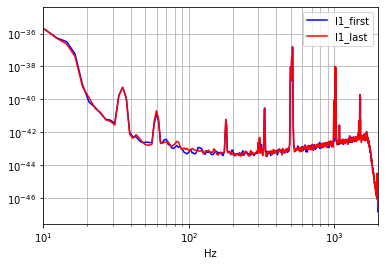

In [19]:
f_l1_first, S_l1_first = welch_bartlett(pdf['l1_first'], 32, 0.5)
f_l1_last, S_l1_last = welch_bartlett(pdf['l1_last'], 32, 0.5)
plt.loglog(f_l1_first, S_l1_first, 'b')
plt.loglog(f_l1_last, S_l1_last, 'r')
plt.grid(True, which="both")
plt.xlabel("Hz")
plt.xlim(10, 2000)
plt.legend(["l1_first", "l1_last"])
plt.show()

We can observe that for each segment, where it belongs to L1 or H1, each first/last psd overlaps in most part. This result, and the probability distributions observed previously, strongly leads us to asume stationary noise.

# Data Whitening

For whitening the signal, welch estimation was used with the parameters shown below.

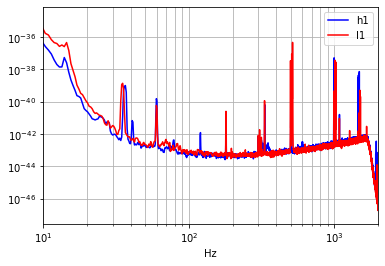

In [20]:
K_choosen = 32
D_choosen = 0.5
f_w_b, h1_welch_bartlett = welch_bartlett(h1_dataset, K_choosen, D_choosen)
f_w_b, l1_welch_bartlett = welch_bartlett(l1_dataset, K_choosen, D_choosen)

plot_h1_l1(h1_welch_bartlett, l1_welch_bartlett, f_w_b)

In [21]:
def whitening(f, psd_interp, dataset, fs, show = False):

  dataset_transformed = np.fft.rfft(dataset)
  freqs = np.fft.rfftfreq(len(dataset), 1/fs)
  spec = psd_interp(freqs)
  white_spec = dataset_transformed / np.sqrt(spec)
  if show:
    plt.title("white spectrum")
    plt.loglog(freqs, white_spec)
  time_domain_whiten = np.fft.irfft(white_spec)
  bb, ab = butter(4, [20.*2./fs, 200.*2./fs], btype='band')
  time_domain_whiten = filtfilt(bb, ab, time_domain_whiten)

  return time_domain_whiten

interpol_psd_h1 = interp1d(f_w_b, h1_welch_bartlett, fill_value="extrapolate")
interpol_psd_l1 = interp1d(f_w_b, l1_welch_bartlett, fill_value="extrapolate")

signal_h1 = whitening(f_w_b, interpol_psd_h1, h1_dataset * np.hanning(len(h1_dataset)), 4096)
signal_l1 = whitening(f_w_b, interpol_psd_l1, l1_dataset * np.hanning(len(h1_dataset)), 4096)

sample_start = int(chirp_second_min+0.33*fs)
sample_end = int(chirp_second_max-0.53*fs)

def plot_time_signals(signal_h1, signal_l1, sample_start, sample_end):

  plt.title("signals")
  plt.plot(
      x_in_seconds[sample_start:sample_end], 
      signal_h1[sample_start:sample_end], 
      color='b'
      )
  plt.plot(
      x_in_seconds[sample_start:sample_end], 
      signal_l1[sample_start:sample_end], 
      color='r'
      )
  plt.grid(True, which="both")
  plt.xlabel('time in seconds')


### Spectrogram h1, l1 before and after whitening

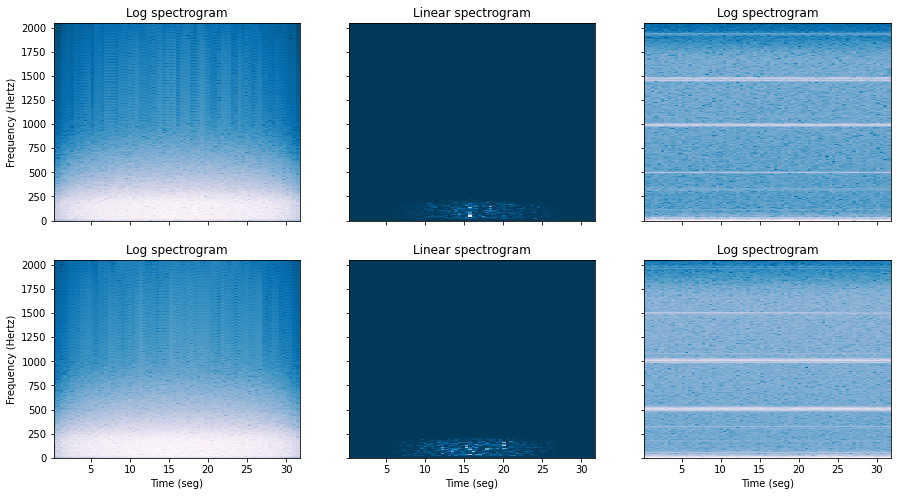

In [67]:
from matplotlib.colors import LogNorm 
from matplotlib.colors import Normalize

f_h1, t_h1, Sxx_h1 = signal.spectrogram(signal_h1, fs, nperseg=int(fs/2))   #spectrogram with whitening
f_h1_x, t_h1_x, Sxx_h1_x = signal.spectrogram(h1_dataset, fs, nperseg=int(fs/2)) #spectrogram without whitening
f_l1, t_l1, Sxx_l1 = signal.spectrogram(signal_l1, fs, nperseg=int(fs/2))    #spectrogram with withening
f_l1_x, t_l1_x, Sxx_l1_x = signal.spectrogram(l1_dataset, fs, nperseg=int(fs/2)) #spectrogram without withening


fig, axes = plt.subplots(nrows=2, ncols=3,sharex=True, figsize=(15,8))

F = [[f_h1, f_h1, f_h1_x], [f_l1, f_l1, f_l1_x]]
T = [[t_h1, t_h1, t_h1_x], [t_l1, t_l1, t_l1_x]]
S = [[Sxx_h1, Sxx_h1, Sxx_h1_x], [Sxx_l1, Sxx_l1, Sxx_l1_x]]

for i in range(2):
  for j in range(3):
    axes[i][j].set_xlabel('Time (seg)')
    axes[i][j].set_ylabel('Frequency (Hertz)')
    axes[i][j].label_outer()
    if j == 1:
      axes[i][j].pcolormesh(T[i][j], F[i][j], (S[i][j]), norm=Normalize(vmin=S[i][j].min(), vmax=S[i][j].max()),cmap='PuBu_r')
      axes[i][j].set_title('Linear spectrogram')
    else:
      axes[i][j].pcolormesh(T[i][j], F[i][j], (S[i][j]), norm=LogNorm(vmin=S[i][j].min(), vmax=S[i][j].max()),cmap='PuBu_r')
      axes[i][j].set_title('Log spectrogram')
    #axes[i][j].title_outer()

plt.show()

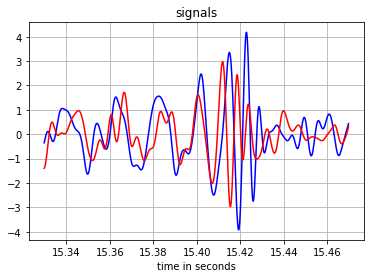

In [23]:
plot_time_signals(signal_h1, signal_l1, sample_start, sample_end)

### L1 audio

Audio file for L1 chirp

In [24]:
Audio(signal_l1[int(chirp_second_min-fs):int(chirp_second_max+fs)], rate=4096)

### H1 audio

Audio file for H1 chirp

In [25]:
Audio(signal_h1[int(chirp_second_min-fs):int(chirp_second_max+fs)], rate=4096)


##### The whitening is repetead but this time the signal used is the 200ms segments in which there is the gravitational wave.


In [26]:
fs = 4096
sample_start = int(chirp_second_min + 0.3 * fs)
sample_end = int(chirp_second_max - 0.5 * fs)
duration_samples = (sample_end - sample_start)
duration_ms = duration_samples * 1000 / 4096

print(duration_ms)

# Preparing the segment extracting 200 ms, with zero padding and hanning windowing...

n_zeros = 1000
h1_zero_padded = np.zeros(n_zeros + duration_samples + n_zeros)
h1_zero_padded[n_zeros:n_zeros+duration_samples] = h1_dataset[sample_start:sample_end] * np.hanning(duration_samples)
l1_zero_padded = np.zeros(n_zeros + duration_samples + n_zeros)
l1_zero_padded[n_zeros:n_zeros+duration_samples] = l1_dataset[sample_start:sample_end] * np.hanning(duration_samples)

signal_h1_cut = whitening(f_w_b, interpol_psd_h1, h1_zero_padded, 4096)
signal_l1_cut = whitening(f_w_b, interpol_psd_l1, l1_zero_padded, 4096)

200.1953125


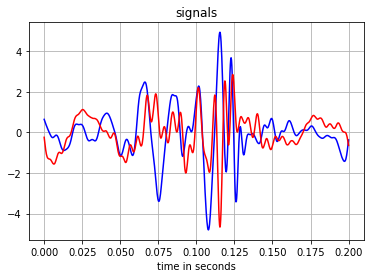

In [27]:
plot_time_signals(signal_h1_cut[n_zeros:n_zeros+duration_samples], signal_l1_cut[n_zeros:n_zeros+duration_samples], 0, len(signal_h1_cut[n_zeros:n_zeros+duration_samples]))

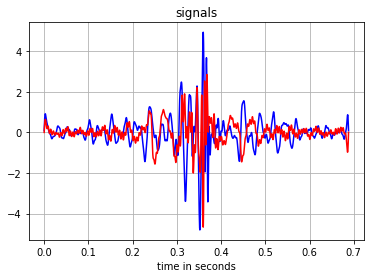

In [28]:
plot_time_signals(signal_h1_cut, signal_l1_cut, 0, len(signal_h1_cut))

In [29]:
def prepare_short_audio(signal, fs):
  audio_len = 3*4096
  audio_context = np.zeros(audio_len)
  audio_context[int(audio_len/2):int(audio_len/2) + len(signal)] = signal
  return audio_context

Audio(prepare_short_audio(signal_h1_cut, fs), rate=fs)

In [30]:
Audio(prepare_short_audio(signal_l1_cut, fs), rate=fs)

### Time offset between interferometers signals...

In order to calculate de time difference between the two signals, it can be used the correlation, because it reaches the maximum being evaluated at the distance in samples that represents the difference looked for.

In [31]:
"""
cross_corr = np.correlate(signal_h1, signal_l1, 'same')
delta_t_ms = np.argmax(cross_corr)*1000/4096
print(delta_t_ms)
plt.plot(cross_corr[65000:70000])
"""
cross_corr = np.correlate(signal_h1, signal_l1, 'same')
delta_t_s = np.argmax(abs(cross_corr)) / 4096
print(f'Delay between both signals: {round((delta_t_s-np.mean(x_in_seconds)) * 1000, 2)} ms')

Delay between both signals: 7.69 ms
